In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from pathlib import Path
import gc

<h1> Machine Learning Models </h1>

In [2]:
path = Path('../data/quora')
list(path.iterdir())

[PosixPath('../data/quora/df_fe_without_preprocessing_train.csv'),
 PosixPath('../data/quora/final_features.csv'),
 PosixPath('../data/quora/final_features_fth'),
 PosixPath('../data/quora/nlp_features_train.csv'),
 PosixPath('../data/quora/quora-question-pairs.zip'),
 PosixPath('../data/quora/sample_submission.csv'),
 PosixPath('../data/quora/train.csv'),
 PosixPath('../data/quora/train_n.txt'),
 PosixPath('../data/quora/train_p.txt')]

In [6]:
data = pd.read_csv(path/'final_features.csv')
data.head()

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,...,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,...,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.478689


In [7]:
data.to_feather(path/'final_features_fth')

In [20]:
data = pd.read_feather(path/'final_features_fth')

In [11]:
gc.collect()

15

In [21]:
data.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)

In [22]:
data.head()

,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,...,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,...,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,...,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075
3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,...,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,...,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.478689


<h2> Random train test split( 70:30) </h2>

In [23]:
def get_sample(df, n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [50]:
df = get_sample(data, 10000)

In [51]:
y_true = df['is_duplicate']
df.drop(['is_duplicate'], axis=1, inplace=True)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.2)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)



In [53]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)
print("Number of data points in test data :",X_cv.shape)

Number of data points in train data : (6400, 794)
Number of data points in test data : (2000, 794)
Number of data points in test data : (1600, 794)


In [54]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)

print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

print("-"*10, "Distribution of output variable in cv data", "-"*10)
cv_distr = Counter(y_cv)
cv_len = len(y_cv)
print("Class 0: ",int(cv_distr[0])/cv_len, "Class 1: ",int(cv_distr[1])/cv_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.63015625 Class 1:  0.36984375
---------- Distribution of output variable in test data ----------
Class 0:  0.63 Class 1:  0.37
---------- Distribution of output variable in cv data ----------
Class 0:  0.63 Class 1:  0.37


In [37]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
    
    

Log loss on Test Data using Random Model 0.8887140524529333


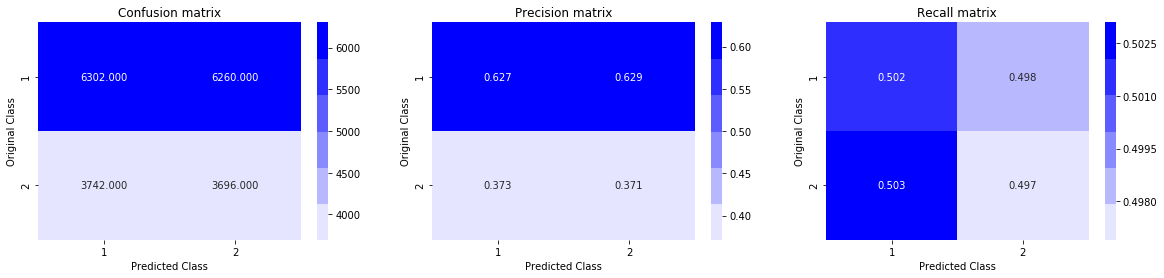

In [38]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> Logistic Regression with hyperparameter tuning </h2>

In [40]:
alphas = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error = []
for alpha in alphas:
    clf = SGDClassifier(alpha=alpha, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    clf_clb = CalibratedClassifierCV(clf, method="sigmoid")
    clf_clb.fit(X_train, y_train)
    predict_y = clf_clb.predict_proba(X_cv)
    loss = log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
    log_error.append(loss)
    print(f'For values of alpha = {alpha}, The log loss is:: {loss}')


For values of alpha = 1e-05, The log loss is:: 0.6599460554236883
For values of alpha = 0.0001, The log loss is:: 0.4526094862747391
For values of alpha = 0.001, The log loss is:: 0.4543383971986447
For values of alpha = 0.01, The log loss is:: 0.4514883067902497
For values of alpha = 0.1, The log loss is:: 0.46721612784870054
For values of alpha = 1, The log loss is:: 0.4704843311109969
For values of alpha = 10, The log loss is:: 0.5087046919932283


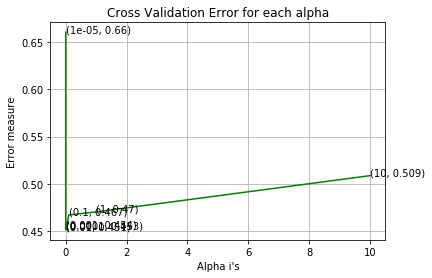

In [41]:
fig, ax = plt.subplots()
ax.plot(alphas, log_error, c='g')
for i, txt in enumerate(np.round(log_error, 3)):
    ax.annotate((alphas[i], np.round(txt, 3)), (alphas[i], log_error[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.01 The train log loss is: 0.44831539810890053
For values of best alpha =  0.01 The test log loss is: 0.4515969391564091
Total number of data points : 20000


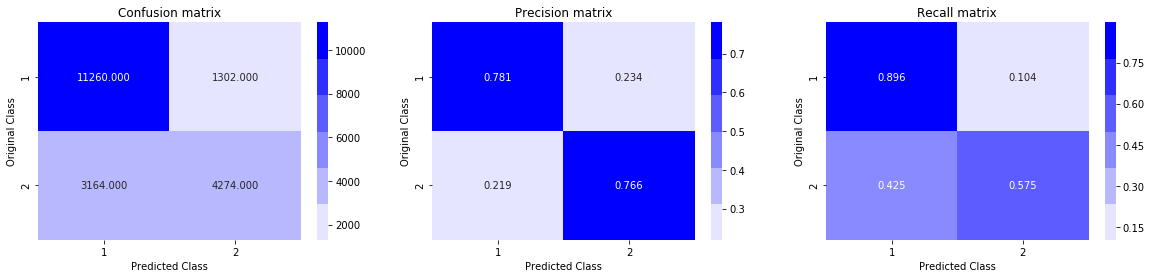

In [44]:
best_alpha = np.argmin(log_error)
clf = SGDClassifier(alpha=alphas[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
clf_clb = CalibratedClassifierCV(clf, method="sigmoid")
clf_clb.fit(X_train, y_train)

predict_y = clf_clb.predict_proba(X_train)
print('For values of best alpha = ', alphas[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_clb.predict_proba(X_test)
print('For values of best alpha = ', alphas[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> Linear SVM with hyperparameter tuning </h2>

In [46]:
# alphas = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
# log_error = []
# for alpha in alphas:
#     clf = SGDClassifier(alpha=alpha, penalty='l1', loss='hinge', random_state=42)
#     clf.fit(X_train, y_train)
#     clf_clb = CalibratedClassifierCV(clf, method="sigmoid")
#     clf_clb.fit(X_train, y_train)
#     predict_y = clf_clb.predict_proba(X_cv)
#     loss = log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
#     log_error.append(loss)
#     print(f'For values of alpha = {alpha}, The log loss is:: {loss}')

# fig, ax = plt.subplots()
# ax.plot(alphas, log_error, c='g')
# for i, txt in enumerate(np.round(log_error, 3)):
#     ax.annotate((alphas[i], np.round(txt, 3)), (alphas[i], log_error[i]))

# plt.grid()
# plt.title("Cross Validation Error for each alpha")
# plt.xlabel("Alpha i's")
# plt.ylabel("Error measure")
# plt.show()


# best_alpha = np.argmin(log_error)
# clf = SGDClassifier(alpha=alphas[best_alpha], penalty='l1', loss='hinge', random_state=42)
# clf.fit(X_train, y_train)
# clf_clb = CalibratedClassifierCV(clf, method="sigmoid")
# clf_clb.fit(X_train, y_train)

# predict_y = clf_clb.predict_proba(X_train)
# print('For values of best alpha = ', alphas[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
# predict_y = clf_clb.predict_proba(X_test)
# print('For values of best alpha = ', alphas[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
# predicted_y =np.argmax(predict_y,axis=1)
# print("Total number of data points :", len(predicted_y))
# plot_confusion_matrix(y_test, predicted_y)

<h2> Random Forest </h2>

For values of alpha = 100 and value for depth = 5, The log loss is:: 0.45801719950749925
For values of alpha = 100 and value for depth = 10, The log loss is:: 0.43113160999550376
For values of alpha = 200 and value for depth = 5, The log loss is:: 0.4525609516872848
For values of alpha = 200 and value for depth = 10, The log loss is:: 0.4279104632153927


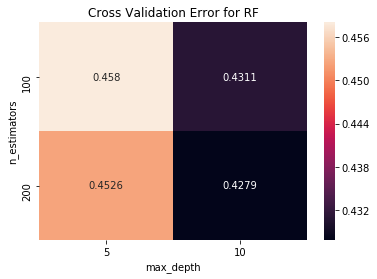

For values of best alpha =  0.01 The train log loss is: 0.2100410184595701
For values of best alpha =  0.01 The test log loss is: 0.4464192248116011
Total number of data points : 2000


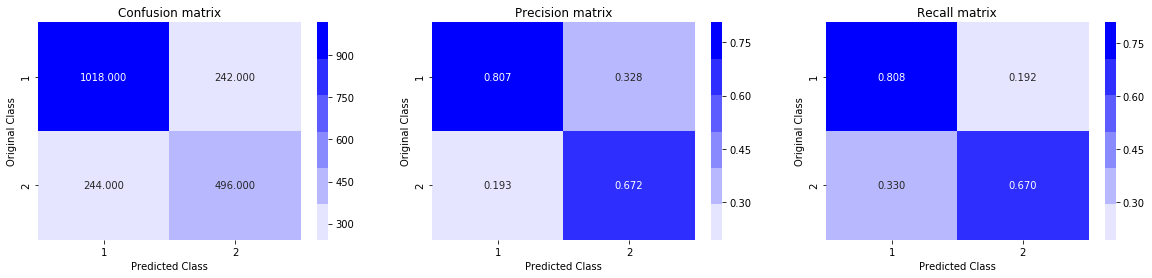

In [64]:
estimators = [100,200]
depths = [5, 10]

log_error = []
for estimator in estimators:
    cv_error = []
    for depth in depths:
        clf = RandomForestClassifier(n_estimators=estimator, criterion='gini', max_depth=depth, random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train)
        clf_clb = CalibratedClassifierCV(clf, method="sigmoid")
        clf_clb.fit(X_train, y_train)
        predict_y = clf_clb.predict_proba(X_cv)
        loss = log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
        print(f'For values of alpha = {estimator} and value for depth = {depth}, The log loss is:: {loss}')
        cv_error.append(loss)
    log_error.append(cv_error)
log_error=np.array(log_error)

n = len(estimators)
m = len(depths)
df_plot = pd.DataFrame(data=log_error, index=estimators, columns=depths)
sns.heatmap(df_plot, annot = True, fmt='.4g')
plt.title("Cross Validation Error for RF")
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.show()


indx = np.unravel_index(np.argmin(log_error, axis=None), log_error.shape)
best_estimator = estimators[indx[0]]
best_depth = depths[indx[1]]

clf = RandomForestClassifier(n_estimators=best_estimator, criterion='gini', max_depth=best_depth, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
clf_clb = CalibratedClassifierCV(clf, method="sigmoid")
clf_clb.fit(X_train, y_train)

predict_y = clf_clb.predict_proba(X_train)
print('For values of best alpha = ', alphas[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_clb.predict_proba(X_test)
print('For values of best alpha = ', alphas[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [63]:

log_error

[0.4580171995074994,
 0.43113160999550376,
 [0.4580171995074994, 0.43113160999550376],
 0.4525609516872848,
 0.4279104632153926,
 [0.4525609516872848, 0.4279104632153926]]

<h2> XGBoost Classifier </h2>

For values of alpha = 100 and value for depth = 5, The log loss is:: 0.38454353225840665
For values of alpha = 100 and value for depth = 10, The log loss is:: 0.38454353225840665
For values of alpha = 200 and value for depth = 5, The log loss is:: 0.38454353225840665
For values of alpha = 200 and value for depth = 10, The log loss is:: 0.38454353225840665


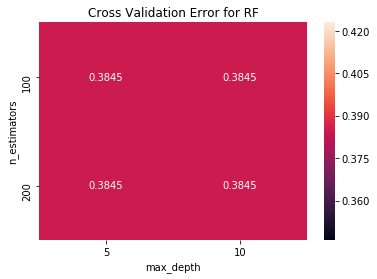

For values of best alpha =  0.01 The train log loss is: 0.19163324224589595
For values of best alpha =  0.01 The test log loss is: 0.4165728940051301
Total number of data points : 2000


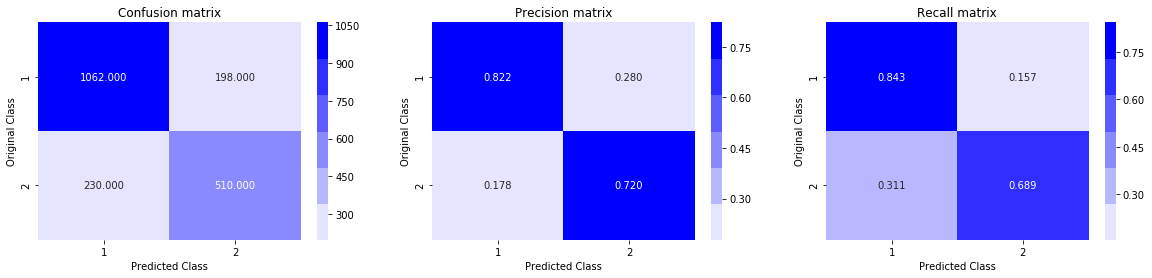

In [68]:
estimators = [100,200]
depths = [5, 10]

log_error = []
for estimator in estimators:
    cv_error = []
    for depth in depths:
        clf = xgb.XGBClassifier(scale_pos_weight=float(np.sum(y_train == 0) / np.sum(y_train == 1)))
        clf.fit(X_train, y_train)
        clf_clb = CalibratedClassifierCV(clf, method="sigmoid")
        clf_clb.fit(X_train, y_train)
        predict_y = clf_clb.predict_proba(X_cv)
        loss = log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
        print(f'For values of alpha = {estimator} and value for depth = {depth}, The log loss is:: {loss}')
        cv_error.append(loss)
    log_error.append(cv_error)
log_error=np.array(log_error)

n = len(estimators)
m = len(depths)
df_plot = pd.DataFrame(data=log_error, index=estimators, columns=depths)
sns.heatmap(df_plot, annot = True, fmt='.4g')
plt.title("Cross Validation Error for RF")
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.show()


indx = np.unravel_index(np.argmin(log_error, axis=None), log_error.shape)
best_estimator = estimators[indx[0]]
best_depth = depths[indx[1]]

clf = xgb.XGBClassifier(max_depth=best_depth, n_estimators=best_estimator, scale_pos_weight=float(np.sum(y_train == 0) / np.sum(y_train == 1)))
clf.fit(X_train, y_train)
clf_clb = CalibratedClassifierCV(clf, method="sigmoid")
clf_clb.fit(X_train, y_train)

predict_y = clf_clb.predict_proba(X_train)
print('For values of best alpha = ', alphas[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_clb.predict_proba(X_test)
print('For values of best alpha = ', alphas[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> Light GBM </h2>

In [ ]:
estimators = [100,200]
depths = [5, 10]

log_error = []
for estimator in estimators:
    cv_error = []
    for depth in depths:
        clf = xgb.XGBClassifier(scale_pos_weight=float(np.sum(y_train == 0) / np.sum(y_train == 1)))
        clf.fit(X_train, y_train)
        clf_clb = CalibratedClassifierCV(clf, method="sigmoid")
        clf_clb.fit(X_train, y_train)
        predict_y = clf_clb.predict_proba(X_cv)
        loss = log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
        print(f'For values of alpha = {estimator} and value for depth = {depth}, The log loss is:: {loss}')
        cv_error.append(loss)
    log_error.append(cv_error)
log_error=np.array(log_error)

n = len(estimators)
m = len(depths)
df_plot = pd.DataFrame(data=log_error, index=estimators, columns=depths)
sns.heatmap(df_plot, annot = True, fmt='.4g')
plt.title("Cross Validation Error for RF")
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.show()


indx = np.unravel_index(np.argmin(log_error, axis=None), log_error.shape)
best_estimator = estimators[indx[0]]
best_depth = depths[indx[1]]

clf = xgb.XGBClassifier(max_depth=best_depth, n_estimators=best_estimator, scale_pos_weight=float(np.sum(y_train == 0) / np.sum(y_train == 1)))
clf.fit(X_train, y_train)
clf_clb = CalibratedClassifierCV(clf, method="sigmoid")
clf_clb.fit(X_train, y_train)

predict_y = clf_clb.predict_proba(X_train)
print('For values of best alpha = ', alphas[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_clb.predict_proba(X_test)
print('For values of best alpha = ', alphas[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> Stack the models </h2>

In [ ]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
clf1_calib = CalibratedClassifierCV(clf1, method="sigmoid")
clf1_calib.fit(X_train, y_train)

clf2 = RandomForestClassifier(n_estimators=best_estimator, criterion='gini', max_depth=best_depth, random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
clf2_calib = CalibratedClassifierCV(clf2, method="sigmoid")
clf2_calib.fit(X_train, y_train)

clf3 = xgb.XGBClassifier(max_depth=best_depth, n_estimators=best_estimator, scale_pos_weight=float(np.sum(y_train == 0) / np.sum(y_train == 1)))
clf3.fit(train_x_onehotCoding, train_y)
clf3_calib = CalibratedClassifierCV(clf3, method="sigmoid")
clf3_calib.fit(X_train, y_train)
         
    
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(X_test))))

print("Random Forest : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(X_test))))

print("XG Boost : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(X_tes))))
print("="*50)


alpha = [0.0001,0.001,0.01,0.1,1,10]
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(X_train, train_y)
    log_error = log_loss(y_cv, sclf.predict_proba(X_cv))
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_error))
    if best_alpha > log_error:
        best_alpha = log_error
                              